In [1]:
import numpy as np
import pandas as pd
import math

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('D:/Papers/paper_code/new/Data/Processed/Solar_data.csv')

In [3]:
data.head()

,DATE_TIME,DAILY_YIELD,lag_1,lag_2,lag_DY,Month,Day,Hour,Minute,Weekday
0,2020/5/17 5:00,0.0,0.0,0.0,0.0,0,0.533333,0.217391,0.000000,1.0
1,2020/5/17 5:15,0.0,0.0,0.0,0.0,0,0.533333,0.217391,0.333333,1.0
2,2020/5/17 5:30,0.0,0.0,0.0,0.0,0,0.533333,0.217391,0.666667,1.0
3,2020/5/17 5:45,0.0,0.0,0.0,0.0,0,0.533333,0.217391,1.000000,1.0
4,2020/5/17 6:00,0.0,0.0,0.0,0.0,0,0.533333,0.260870,0.000000,1.0


In [4]:
train = data[:-192]
test = data[-192:]
print(train.shape)
print(test.shape)

(2734, 10)
(192, 10)


In [5]:
x_train = train.drop(columns = {'DATE_TIME','DAILY_YIELD'}, axis = 1)
y_train = train.loc[:, ['DAILY_YIELD']]

x_test = test.drop(columns = {'DATE_TIME','DAILY_YIELD'}, axis = 1)
y_test = test.loc[:, ['DAILY_YIELD']]

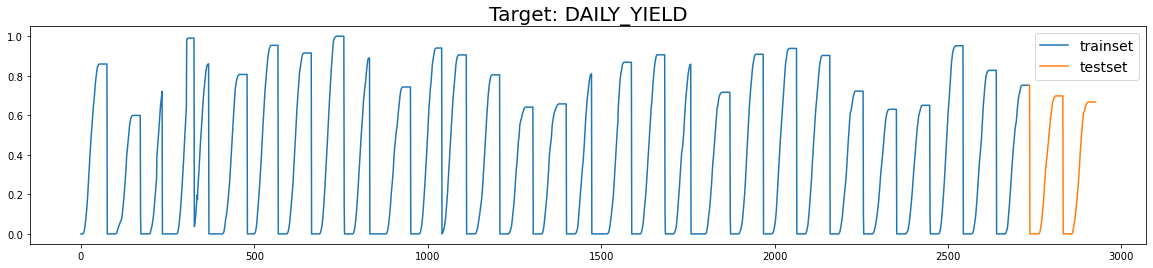

In [6]:
sns.reset_orig()
plt.figure(figsize = (20,4))
plt.title('Target: DAILY_YIELD', fontsize = 20)
plt.plot(y_train['DAILY_YIELD'], label = 'trainset')
plt.plot(y_test['DAILY_YIELD'], label = 'testset')

plt.legend(fontsize = 14)
plt.show()

# LightGBM

In [7]:
import lightgbm as lgb

In [8]:
model = lgb.LGBMRegressor().fit(x_train, y_train)

pred = model.predict(x_test)
r2 = r2_score(pred, y_test)
mse = mean_squared_error(pred, y_test)

print('R2: ', r2, '  ;  ', 'MSE: ', mse)

R2:  0.9322907948421464   ;   MSE:  0.00529520207748286


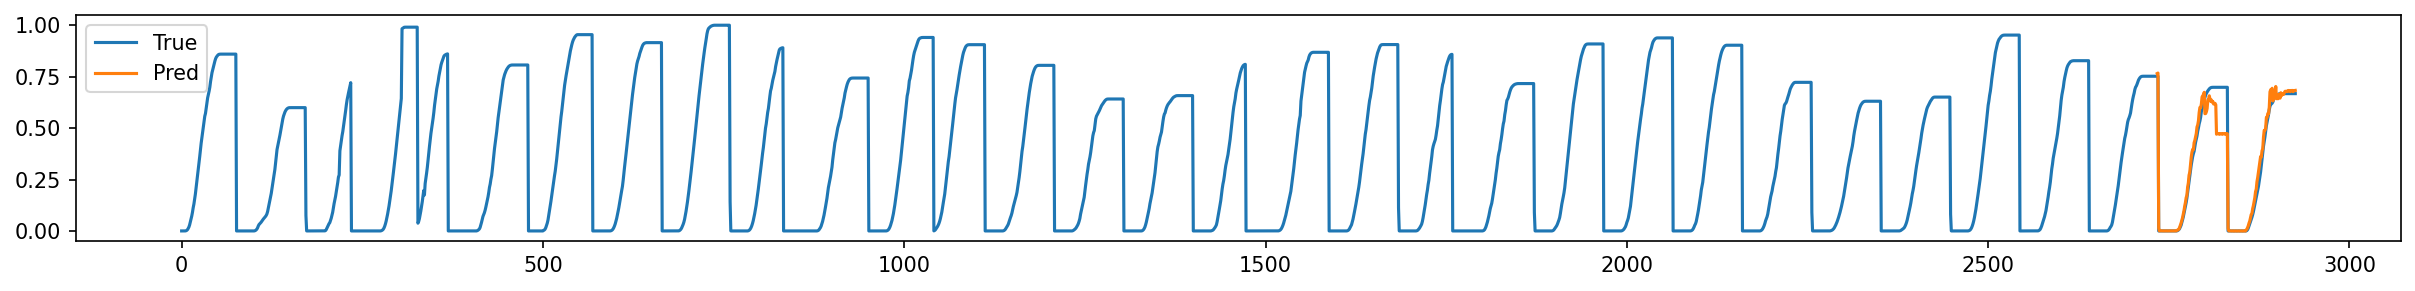

In [9]:
prediction = pd.DataFrame(pred, index=y_test.index)

sns.reset_orig()
plt.figure(figsize = (20,2), dpi=150)

plt.plot(data['DAILY_YIELD'], label = 'True')
plt.plot(prediction, label = 'Pred')

plt.legend()

plt.show()

# Interpretation of XGBoost

In [10]:
import ShapTimeBoosting
from ShapTimeBoosting import supertime, ShapleyValues, TimeImportance, TimeHeatmap

In [11]:
# The training set is evenly divided into 11 parts in the time dimension, 
# and the importance of each part is calculated.
Tn= 10
interp_x= x_train
model = model

ShapTime_lgb = ShapleyValues(model, interp_x, Tn)

In [12]:
ShapTime_lgb

[-0.028833275617145347,
 0.01126094039499479,
 0.02184873152850486,
 0.008312083336533221,
 -0.011002640776858447,
 -0.021247724255284865,
 -0.011275317418592857,
 0.026623349888735257,
 -0.012319150169172061,
 0.01718570296072723]

In [13]:
# name these time periods
time_columns =  ['t0', 't1', 't2', 't3', 't4', 't5', 't6', 't7', 't8', 't9']

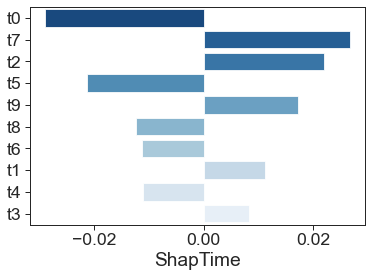

In [14]:
TimeImportance(Tn, ShapTime_lgb, time_columns)

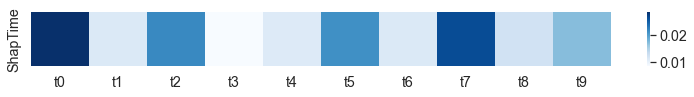

In [15]:
TimeHeatmap(Tn, ShapTime_lgb, time_columns)

# Evaluation of Interpretation

### Feature-Independence

In [16]:
import EvaluationBoosting
from ShapTimeBoosting import FeaIndepenVal, PlotVal

In [17]:
n = 4
Tn = 10
x_train_val = x_train.copy()
y_train = y_train
initial = ShapTime_lgb
model = lgb.LGBMRegressor()

In [18]:
result = FeaIndepenVal(x_train_val, y_train, initial, model, Tn, n, time_columns)

In [19]:
result

,t0,t1,t2,t3,t4,t5,t6,t7,t8,t9
0,-0.028833,0.011261,0.021849,0.008312,-0.011003,-0.021248,-0.011275,0.026623,-0.012319,0.017186
1,-0.028823,0.011275,0.021721,0.008455,-0.010865,-0.021360,-0.011326,0.026515,-0.012366,0.017327
2,-0.028785,0.011203,0.021734,0.008150,-0.010727,-0.021349,-0.011202,0.026523,-0.012402,0.017404
3,-0.028672,0.010968,0.022067,0.008106,-0.010779,-0.021433,-0.011114,0.026623,-0.012443,0.017232
4,-0.028672,0.010968,0.022067,0.008106,-0.010779,-0.021433,-0.011114,0.026623,-0.012443,0.017232


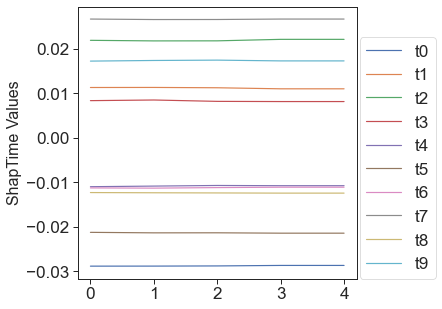

In [20]:
PlotVal(result)

### Sensitivity

In [16]:
situation_0 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
situation_1 = [3, 1, 2, 3, 4, 5, 6, 7, 8, 9]
situation_2 = [3, 1, 2, 3, 4, 5, 6, 3, 8, 9]

In [17]:
total = [situation_0, situation_1, situation_2]
train_eva = train.drop(columns = 'DATE_TIME')
df_eva = supertime(10, train_eva)
model_eva =  lgb.LGBMRegressor()

In [18]:
import EvaluationBoosting
from EvaluationBoosting import evaluation, R2Plot, MSEPlot

In [19]:
r2_results, mse_results = evaluation(df_eva, x_train, y_train, 'DAILY_YIELD', model_eva, total)

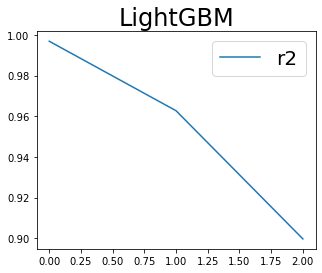

In [20]:
R2Plot(r2_results, 'LightGBM')

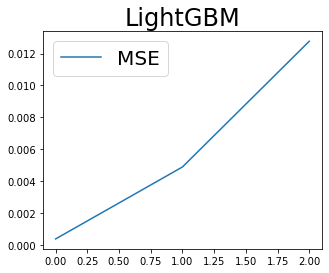

In [21]:
MSEPlot(mse_results, 'LightGBM')

# Improvement

In [27]:
for k in range(Tn):
    exec(f't{k} = supertime(Tn, train)[k]')

In [39]:
check_replist = [t0, t1, t2, t0, t4, t5, t6, t7, t8, t9]

In [40]:
#check
check = pd.concat(check_replist, axis = 0)
x_check = check.drop(columns = {'DATE_TIME','DAILY_YIELD'}, axis = 1)
y_check = check.loc[:, ['DAILY_YIELD']]

model_check = lgb.LGBMRegressor().fit(x_check, y_check)

pred_check = model_check.predict(x_test)
r2_check = r2_score(pred_check, y_test)
mse_check = mean_squared_error(pred_check, y_test)

print(r2_check, 'Degree of Improvement: {:.2%}'.format((r2_check-r2)/abs(r2)))
print(mse_check, 'Degree of Improvement: {:.2%}'.format((mse-mse_check)/mse))

0.9573693033111077 Degree of Improvement: 2.69%
0.003304490930819748 Degree of Improvement: 37.59%


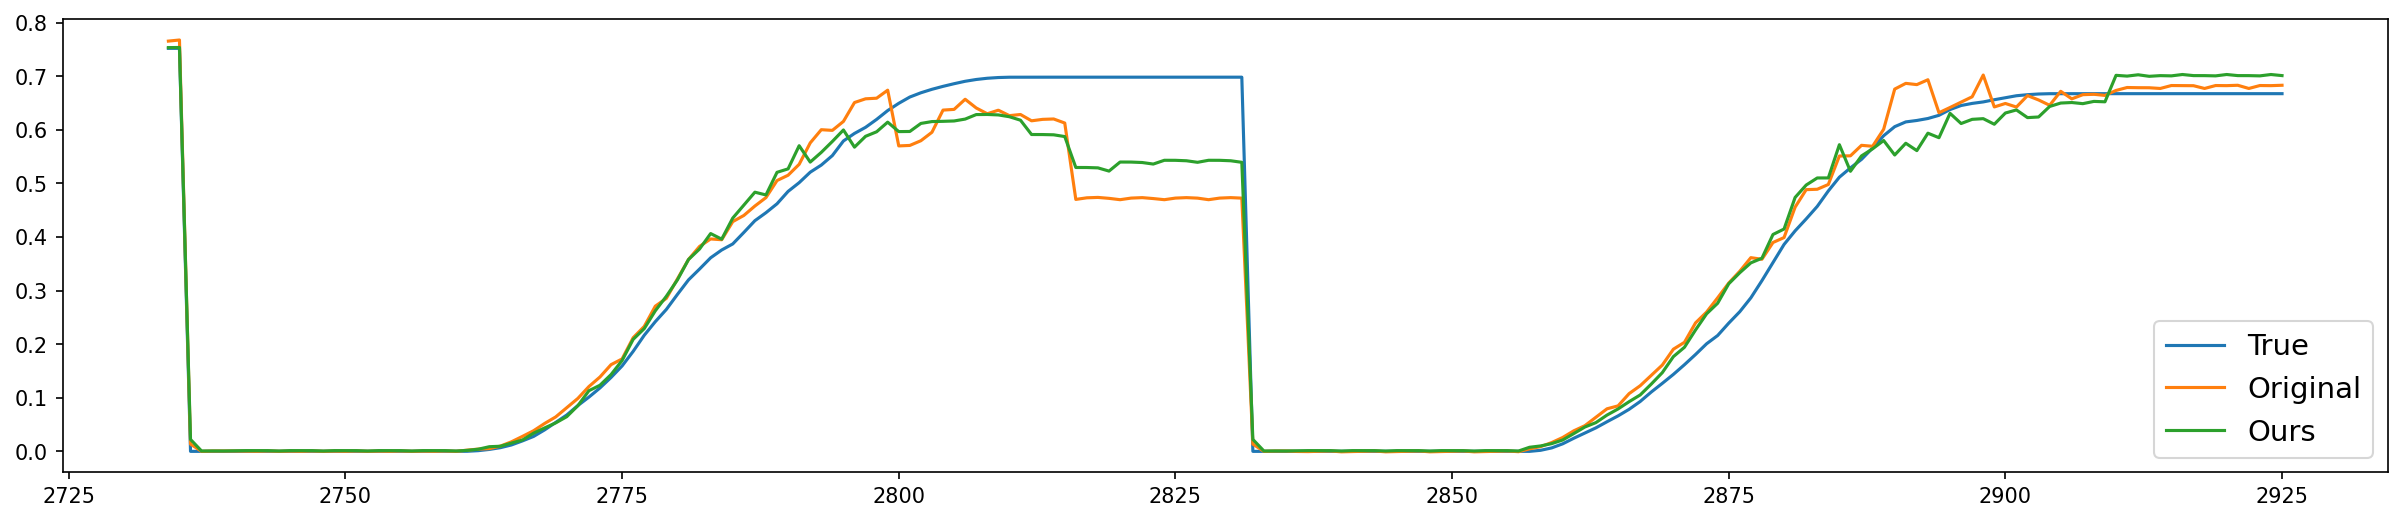

In [41]:
pred_our = pd.DataFrame(pred_check, index=y_test.index)

sns.reset_orig()
plt.figure(figsize = (20,4), dpi=150)

plt.plot(y_test['DAILY_YIELD'], label = 'True')
plt.plot(prediction, label = 'Original')
plt.plot(pred_our, label = 'Ours')

plt.legend(fontsize = 14)
plt.show()